In [1]:
import numpy as np
import tensorflow as tf
from sklearn import model_selection
from PIL import Image
import time
import pandas as pd

import os
from scipy import ndimage, misc
import glob
import pickle
import multiprocessing as mp

In [2]:
data = pd.read_csv('files/Anno/list_attr_celeba.txt', delim_whitespace = True, header=1)
df = data['Eyeglasses']
df = (df + 1)/2
d = np.eye(2)[df.values.astype(int)]

In [3]:
usingImages = 10000
nClasses = 2
shape1 = 178
shape2 = 218
printEvery = 1
batchSize = 100

In [4]:
# images = np.array([np.array(Image.open("files/Img/img_align_celeba/"+str(fname)).resize((shape1, shape2))) for fname in df.head(usingImages).index])
# images = np.float32(images)/256
# with open('my.pickle', 'wb') as handle:
#     pickle.dump(images, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
images.shape

NameError: name 'images' is not defined

In [6]:
with open('my.pickle', 'rb') as handle:
    images = pickle.load(handle)

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, d[:usingImages], test_size=0.20, shuffle=False)
X_validate, X_test, y_validate, y_test = model_selection.train_test_split(X_test, y_test, test_size=0.50, shuffle=False)

In [8]:
X_train.shape

(8000, 218, 178, 3)

In [9]:
df.head(usingImages).shape

(10000,)

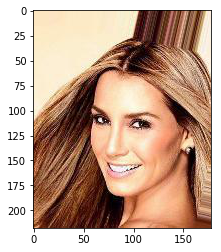

In [10]:
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(X_train[0])

In [11]:
x = tf.placeholder(tf.float32, [None, shape2, shape1, 3])
t = tf.placeholder(tf.float32, [None,2])

In [12]:
def convolutionalNeuralNetwork(x):
    weights = {'conv1':tf.Variable(tf.random_normal([5,5,3,64])),
               'conv2':tf.Variable(tf.random_normal([5,5,64,64])),
               'conv3':tf.Variable(tf.random_normal([5,5,64,64])),
               'conv4':tf.Variable(tf.random_normal([5,5,64,64])),
#                'fullyC1':tf.Variable(tf.random_normal([8*7*64,1024])),
               'fullyC1':tf.Variable(tf.random_normal([14*12*64,1024])),
               'fullyC2':tf.Variable(tf.random_normal([1024,1024])),
               'out':tf.Variable(tf.random_normal([1024,nClasses]))}
    
    biases = {'conv1':tf.Variable(tf.random_normal([64])),
              'conv2':tf.Variable(tf.random_normal([64])),
              'conv3':tf.Variable(tf.random_normal([64])),
              'conv4':tf.Variable(tf.random_normal([64])),
              'fullyC1':tf.Variable(tf.random_normal([1024])),
              'fullyC2':tf.Variable(tf.random_normal([1024])),
              'out':tf.Variable(tf.random_normal([nClasses]))}

    print(x.shape)
    conv1 = tf.nn.relu(tf.nn.conv2d(input=x, filter=weights['conv1'],strides=[1,1,1,1],padding='SAME')+ biases['conv1'])
    conv1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1] ,strides=[1,2,2,1], padding='SAME')
    print(conv1)
    
    conv2 = tf.nn.relu(tf.nn.conv2d(input=conv1, filter=weights['conv2'],strides=[1,1,1,1],padding='SAME') + biases['conv2'])
    conv2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1] ,strides=[1,2,2,1], padding='SAME')
    print(conv2)
    
    conv3 = tf.nn.relu(tf.nn.conv2d(input=conv2, filter=weights['conv3'],strides=[1,1,1,1],padding='SAME') + biases['conv3'])
    conv3 = tf.nn.max_pool(conv3,ksize=[1,2,2,1] ,strides=[1,2,2,1], padding='SAME')
    print(conv3)
    
    conv4 = tf.nn.relu(tf.nn.conv2d(input=conv3, filter=weights['conv4'],strides=[1,1,1,1],padding='SAME') + biases['conv4'])
    conv4 = tf.nn.max_pool(conv4,ksize=[1,2,2,1] ,strides=[1,2,2,1], padding='SAME')
    print(conv4)
    
#     conv4 = tf.reshape(conv4,[-1,8*7*64])
    conv4 = tf.reshape(conv4,[-1,14*12*64])
    print(conv4)
    fcLayer1 = tf.nn.relu(tf.matmul(conv4,weights['fullyC1']) + biases['fullyC1'])
    print(fcLayer1)
    fcLayer1 = tf.nn.dropout(fcLayer1,keepRate)
    fcLayer2 = tf.nn.relu(tf.matmul(fcLayer1,weights['fullyC2']) + biases['fullyC2'])
    output = tf.matmul(fcLayer2,weights['out']) + biases['out']
    print(output)
    
#     regLoss = tf.nn.l2_loss(weights['conv1']) + tf.nn.l2_loss(weights['conv2']) + tf.nn.l2_loss(weights['fullyC1']) + tf.nn.l2_loss(weights['fullyC1']) + tf.nn.l2_loss(weights['out'])
    return output

In [13]:
# nEpochs = 2
# keepRate = 0.8
# start_time = time.time()
# y = convolutionalNeuralNetwork(X_train)
# trainNetwork()
# print("--- %s seconds ---" % (time.time() - start_time))

In [14]:
def trainNetwork():
    with tf.name_scope("loss") as scope:
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=tf.transpose(y),labels=tf.transpose(t)))
#         tf.summary.scalar("loss",loss)
    
    with tf.name_scope("training") as scope:
        optimizer = tf.train.AdamOptimizer().minimize(loss)
    
    with tf.name_scope("accuracy") as scope:
        correct = tf.equal(tf.argmax(y),tf.argmax(t))
        accuracy = tf.reduce_mean(tf.cast(correct,'float'))
        
    init = tf.global_variables_initializer()
    sess = tf.Session()
#     mergeSummary = tf.summary.merge_all()

    sess.run(init)
#     summaryWriter = tf.summary.FileWriter('../../TFout/2', sess.graph)

    for epoch in range(nEpochs):
        error = 0.0
        for i in range(int(usingImages*0.8/batchSize)):
            xs = X_train[i*batchSize:(i+1)*batchSize]
            ys = y_train[i*batchSize:(i+1)*batchSize]
#             print(xs.shape, ys.shape,"1")
#             batch_xs, batch_ys = mnist.train.next_batch(batchSize)
            _, er = sess.run([optimizer,loss],feed_dict={x:xs,t:ys})
#             print(xs.shape, ys.shape,i)
#             summaryWriter.add_summary(summaryStr, epoch*(int(m/batchSize)) + i)
            error += er
        if (epoch+1)%printEvery == 0:
            print('Loss in ',epoch+1,' epoch is ',error/(usingImages*0.8))

    prediction = tf.equal(tf.argmax(y),tf.argmax(t))
    accuracy = tf.reduce_mean(tf.cast(prediction,"float"))
#     print("Accuracy Train:", sess.run(accuracy,{x: X_train, t: y_train}))
    print("Accuracy validation:", sess.run(accuracy,{x: X_validate, t: y_validate}))
    print("Accuracy Test:", sess.run(accuracy,{x: X_test, t: y_test}))

In [ ]:
nEpochs = 10
keepRate = 0.8
start_time = time.time()
y = convolutionalNeuralNetwork(x)
print("Y::::::",y)
print(t)
trainNetwork()
print("--- %s seconds ---" % (time.time() - start_time))

(?, 218, 178, 3)
Tensor("MaxPool:0", shape=(?, 109, 89, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 55, 45, 64), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 28, 23, 64), dtype=float32)
Tensor("MaxPool_3:0", shape=(?, 14, 12, 64), dtype=float32)
Tensor("Reshape:0", shape=(?, 10752), dtype=float32)
Tensor("Relu_4:0", shape=(?, 1024), dtype=float32)
Tensor("add_6:0", shape=(?, 2), dtype=float32)
Y:::::: Tensor("add_6:0", shape=(?, 2), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 2), dtype=float32)
Loss in  1  epoch is  1.4464748174e+13
Loss in  2  epoch is  1.47513746183e+16
Loss in  3  epoch is  9.18166438941e+17
Loss in  4  epoch is  1.49236926697e+19
Loss in  5  epoch is  nan
